In [1]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import glob
from tqdm import tqdm
from scipy.special import logsumexp
import os 
import pandas as pd
from functools import reduce
import operator
from scipy.stats import dirichlet
import h5py


import sys
sys.path.append('../')
from populations import bbh_models, gw_obs
import populations.bbh_models as read_models
from populations.bbh_models import read_hdf5
from sample import sample

/data/wiay/2297403c/conda_envs/amaze/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
channels =['CE', 'CHE', 'GC', 'NSC', 'SMT']
file_path='/data/wiay/2297403c/models_reduced.hdf5'
gw_path = "/data/wiay/2297403c/amaze_model_select/AMAZE_model_selection/simulated_events_processed/2_chi02"
np.random.seed(12)
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', 'p_theta_jcb')

model_names, flow = read_models.get_models(file_path, channels, params, use_flows=True, use_unityweights=False, device='cpu',\
     no_bins=[5,4,4,5,4], sensitivity='midhighlatelow')
#model_names, KDE_models = read_models.get_models(file_path, channels, params, use_flows=False, device='cpu', use_unityweights=False, sensitivity='midhighlatelow')

100%|██████████| 5/5 [01:04<00:00, 12.97s/it]


In [3]:
flow_path="/data/wiay/2297403c/amaze_model_select/AMAZE_model_selection/rns/Flows_040924_trainlogalpha/flow_models/"
for chnl in channels: flow[chnl].load_model(flow_path, chnl)

In [3]:
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)
def setInDict(dataDict, mapList, value):
    getFromDict(dataDict, mapList[:-1])[mapList[-1]] = value

model_names.sort()
hyperparams = sorted(list(set([x.split('/', 1)[1] for x in model_names])))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])

hyperparam_dict  = {}
hyperidx=0

while hyperidx < Nhyper:
    hyperidx_with_Nhyper = np.argwhere(np.asarray([len(x.split('/')) for x in hyperparams])>hyperidx).flatten()
    hyperparams_at_level = sorted(set([x.split('/')[hyperidx] for x in np.asarray(hyperparams)[hyperidx_with_Nhyper]]))
    hyperparam_dict[hyperidx] = hyperparams_at_level
    hyperidx += 1

all_models_at_deepest = all([len(x.split('/')[1:])==Nhyper for x in model_names])
while all_models_at_deepest==False:
    # loop until all models have the same length
    for model in model_names:
        # See number of hyperparameters in model, subtract one for channel
        Nhyper_in_model = len(model.split('/'))-1
        kde_hold = getFromDict(KDE_models, model.split('/'))
        # loop until this model has all the hyperparam levels as well
        while Nhyper_in_model < Nhyper:
            # remove kde model from old level
            setInDict(KDE_models, model.split('/'), {})
            model_names.remove(model)
            for new_hyperparam in hyperparam_dict[Nhyper_in_model]:
                # copy the same kde model for the higher hyperparam level
                new_kde = deepcopy(kde_hold)
                new_level = model.split('/') + [new_hyperparam]
                setInDict(KDE_models, new_level, new_kde)
                # add new model name
                model_names.append(model+'/'+new_hyperparam)
            Nhyper_in_model += 1
        model_names.sort()
    # see if all models are at deepest level else repeat
    all_models_at_deepest = all([len(x.split('/')[1:])==Nhyper for x in model_names])

In [5]:
submodels_dict = {0: {0: 'chi00', 1: 'chi01', 2: 'chi02', 3: 'chi05'}, 1: {0: 'alpha02', 1: 'alpha05', 2: 'alpha10', 3: 'alpha20', 4: 'alpha50'}}
_concentration = np.ones(len(channels))

In [5]:
models = [f'{channel}/chi02/alpha10' for channel in channels]
for model in models:
    getFromDict(KDE_models, model.split('/')).freeze(obsdata, 990903, data_pdf=p_theta, multiproc=False)


100%|██████████| 250/250 [15:39<00:00,  3.76s/it]


In [40]:
#varying beta_CE with KDE models
no_points = 200

p_betaCE=np.zeros(no_points)
alpha=np.zeros(no_points)
chi_b_id = 2
alpha_id = 2

for i, beta_CE in enumerate(np.linspace(0.05,0.95,no_points)):
    sampler_hyperposts = [2., 2., beta_CE,(1-beta_CE)/5,(1-beta_CE)/5,(1-beta_CE)/5]
    betas = np.concatenate((sampler_hyperposts[2:], [1-np.sum(sampler_hyperposts[2:])]))
    p_betaCE[i] = sample.lnpost(sampler_hyperposts, obsdata, KDE_models, submodels_dict, channels, _concentration, False, 990903, p_theta)

    alpha[i]=0.
    for cidx, channel in enumerate(channels):
        KDE = KDE_models[channel]
        beta = betas[cidx]
        alpha[i] += beta * KDE[submodels_dict[0][chi_b_id]][submodels_dict[1][alpha_id]].alpha

In [6]:
#varying beta_CE with flow models


no_points = 20

observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            1000, 'posteriors', 'p_theta_jcb')

p_betaCE_flow_1000samps=np.zeros(no_points)
alpha_flow_1000samps=np.zeros(no_points)
chi_b_id = 2
alpha_id = 2


for i, beta_CE in enumerate(np.linspace(0.05,0.95,no_points)):
    sampler_hyperposts = [2., 2., beta_CE,(1-beta_CE)/5,(1-beta_CE)/5,(1-beta_CE)/5]
    betas = np.concatenate((sampler_hyperposts[2:], [1-np.sum(sampler_hyperposts[2:])]))
    p_betaCE_flow_1000samps[i] = sample.lnpost(sampler_hyperposts, obsdata, flow, submodels_dict, channels, _concentration, True, 990903, p_theta)

    alpha_flow_1000samps[i]=0.
    for cidx, channel in enumerate(channels):
        beta = betas[cidx]
        if channel == 'CE':
            alpha_flow_1000samps[i] += beta * flow[channel].alpha[tuple([chi_b_id, alpha_id])]
        else:
            alpha_flow_1000samps[i] += beta * flow[channel].alpha[(chi_b_id)]

OMP: Warning #96: Cannot form a team with 44 threads, using 42 instead.
OMP: Hint Consider unsetting KMP_DEVICE_THREAD_LIMIT (KMP_ALL_THREADS), KMP_TEAMS_THREAD_LIMIT, and OMP_THREAD_LIMIT (if any are set).


In [7]:
#varying beta_CE with flow models

no_points = 20

p_betaCE_flow_alpha05_1000samps=np.zeros(no_points)
alpha_flow_alpha05_1000samps=np.zeros(no_points)
chi_b_id = 2
alpha_id = 1


for i, beta_CE in enumerate(np.linspace(0.05,0.95,no_points)):
    sampler_hyperposts = [chi_b_id, alpha_id, beta_CE,(1-beta_CE)/5,(1-beta_CE)/5,(1-beta_CE)/5]
    betas = np.concatenate((sampler_hyperposts[2:], [1-np.sum(sampler_hyperposts[2:])]))
    p_betaCE_flow_alpha05_1000samps[i] = sample.lnpost(sampler_hyperposts, obsdata, flow, submodels_dict, channels, _concentration, True, 990903, p_theta)

    alpha_flow_alpha05_1000samps[i]=0.
    for cidx, channel in enumerate(channels):
        beta = betas[cidx]
        if channel == 'CE':
            alpha_flow_alpha05_1000samps[i] += beta * flow[channel].alpha[tuple([chi_b_id, alpha_id])]
        else:
            alpha_flow_alpha05_1000samps[i] += beta * flow[channel].alpha[(chi_b_id)]

In [11]:
#varying beta_CE with flow models
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', 'p_theta_jcb')
no_points = 20

p_betaCE_flow_alpha05=np.zeros(no_points)
alpha_flow_alpha05=np.zeros(no_points)
chi_b_id = 2
alpha_id = 1


for i, beta_CE in enumerate(np.linspace(0.05,0.95,no_points)):
    sampler_hyperposts = [chi_b_id, alpha_id, beta_CE,(1-beta_CE)/5,(1-beta_CE)/5,(1-beta_CE)/5]
    betas = np.concatenate((sampler_hyperposts[2:], [1-np.sum(sampler_hyperposts[2:])]))
    p_betaCE_flow_alpha05[i] = sample.lnpost(sampler_hyperposts, obsdata, flow, submodels_dict, channels, _concentration, True, 990903, p_theta)

    alpha_flow_alpha05[i]=0.
    for cidx, channel in enumerate(channels):
        beta = betas[cidx]
        if channel == 'CE':
            alpha_flow_alpha05[i] += beta * flow[channel].alpha[tuple([chi_b_id, alpha_id])]
        else:
            alpha_flow_alpha05[i] += beta * flow[channel].alpha[(chi_b_id)]

In [8]:
np.save('flow_logprob_varyingbetaCE_1000Nsamp_alphaCE10.npy', p_betaCE_flow_1000samps, allow_pickle=True)
np.save('flow_logprob_varyingbetaCE_1000Nsamp_alphaCE05.npy', p_betaCE_flow_alpha05_1000samps, allow_pickle=True)
np.save('flow_alpha_varyingbetaCE_1000Nsamp_alphaCE10.npy', -np.log(alpha_flow_1000samps)*obsdata.shape[0], allow_pickle=True)
np.save('flow_alpha_varyingbetaCE_1000Nsamp_alphaCE05.npy', -np.log(alpha_flow_alpha05_1000samps)*obsdata.shape[0], allow_pickle=True)

In [12]:
#varying beta_CE with flow models
no_points = 20

p_betaCE_flow=np.zeros(no_points)
alpha_flow=np.zeros(no_points)
chi_b_id = 2
alpha_id = 2


for i, beta_CE in enumerate(np.linspace(0.05,0.95,no_points)):
    sampler_hyperposts = [chi_b_id, alpha_id, beta_CE,(1-beta_CE)/5,(1-beta_CE)/5,(1-beta_CE)/5]
    betas = np.concatenate((sampler_hyperposts[2:], [1-np.sum(sampler_hyperposts[2:])]))
    p_betaCE_flow[i] = sample.lnlike(sampler_hyperposts, obsdata, flow, submodels_dict, channels,p_theta, True, 990903)

    alpha_flow[i]=0.
    for cidx, channel in enumerate(channels):
        beta = betas[cidx]
        if channel == 'CE':
            alpha_flow[i] += beta * flow[channel].alpha[tuple([chi_b_id, alpha_id])]
        else:
            alpha_flow[i] += beta * flow[channel].alpha[(chi_b_id)]

In [18]:
prior = np.zeros(no_points)
for i, beta_CE in enumerate(np.linspace(0.05,0.95,no_points)):
    sampler_hyperposts = [2., 2., beta_CE,(1-beta_CE)/5,(1-beta_CE)/5,(1-beta_CE)/5]
    betas = np.concatenate((sampler_hyperposts[2:], [1-np.sum(sampler_hyperposts[2:])]))
    prior[i] = dirichlet.logpdf(betas, _concentration)

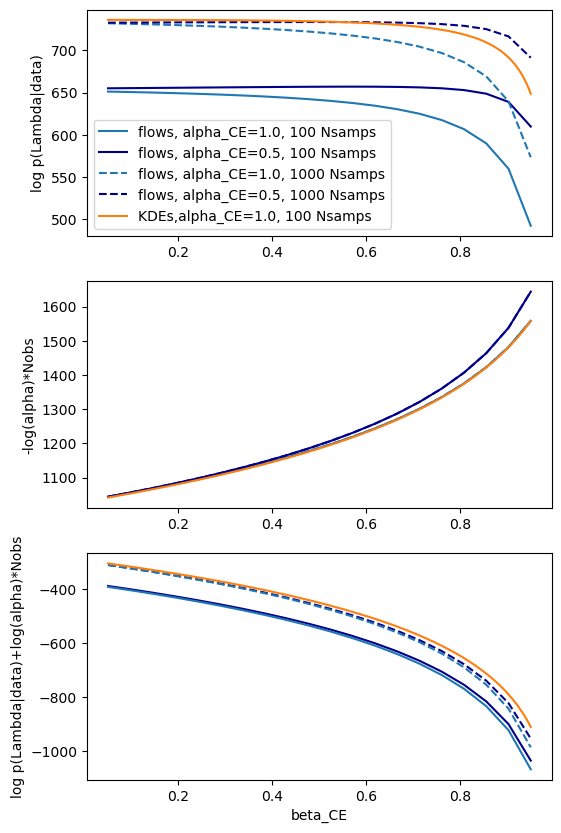

In [13]:
plt.rcParams["figure.figsize"] = (6,10)
fig,ax= plt.subplots(3,1)

p_betaCE = np.load('KDE_logprob_varyingbetaCE.npy')
KDE_alpha = np.load('KDE_alpha_varyingbetaCE.npy')

ax[0].plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow, label='flows, alpha_CE=1.0, 100 Nsamps')
ax[0].plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow_alpha05, color='darkblue', label='flows, alpha_CE=0.5, 100 Nsamps')
ax[0].plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow_1000samps, ls='dashed', color='tab:blue', label='flows, alpha_CE=1.0, 1000 Nsamps')
ax[0].plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow_alpha05_1000samps, color='darkblue', ls='dashed', label='flows, alpha_CE=0.5, 1000 Nsamps')
ax[0].plot(np.linspace(0.05,0.95,200),p_betaCE, label='KDEs,alpha_CE=1.0, 100 Nsamps')

ax[1].plot(np.linspace(0.05,0.95,no_points),-np.log(alpha_flow)*obsdata.shape[0])
ax[1].plot(np.linspace(0.05,0.95,no_points),-np.log(alpha_flow_alpha05)*obsdata.shape[0], color='darkblue')
ax[1].plot(np.linspace(0.05,0.95,no_points),-np.log(alpha_flow_1000samps)*obsdata.shape[0], color='tab:blue', ls='dashed')
ax[1].plot(np.linspace(0.05,0.95,no_points),-np.log(alpha_flow_alpha05_1000samps)*obsdata.shape[0], color='darkblue', ls='dashed')
ax[1].plot(np.linspace(0.05,0.95,200),KDE_alpha)

ax[2].plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow_alpha05+(np.log(alpha_flow_alpha05)*obsdata.shape[0]), color='darkblue')
ax[2].plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow+(np.log(alpha_flow)*obsdata.shape[0]))
ax[2].plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow_alpha05_1000samps+(np.log(alpha_flow_alpha05_1000samps)*obsdata.shape[0]),\
     color='darkblue', ls='dashed')
ax[2].plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow_1000samps+(np.log(alpha_flow_1000samps)*obsdata.shape[0]), color='tab:blue', ls='dashed')
ax[2].plot(np.linspace(0.05,0.95,200),p_betaCE-KDE_alpha)

ax[0].set_ylabel('log p(Lambda|data)')
ax[1].set_ylabel('-log(alpha)*Nobs')
ax[2].set_ylabel('log p(Lambda|data)+log(alpha)*Nobs')
ax[2].set_xlabel('beta_CE')
ax[0].legend()

In [24]:
prior = np.zeros(no_points)
for i, beta_CE in enumerate(np.linspace(0.05,0.95,no_points)):
    sampler_hyperposts = [2., 1., beta_CE,(1-beta_CE)/5,(1-beta_CE)/5,(1-beta_CE)/5]
    betas = np.concatenate((sampler_hyperposts[2:], [1-np.sum(sampler_hyperposts[2:])]))
    prior[i] = dirichlet.logpdf(betas, _concentration)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


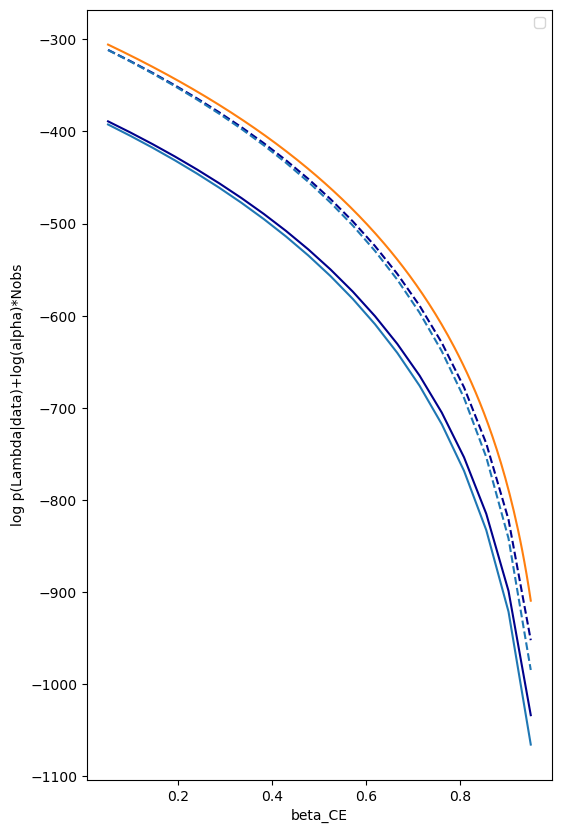

In [14]:
plt.plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow_alpha05+(np.log(alpha_flow_alpha05)*obsdata.shape[0]), color='darkblue')
plt.plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow+(np.log(alpha_flow)*obsdata.shape[0]))
plt.plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow_alpha05_1000samps+(np.log(alpha_flow_alpha05_1000samps)*obsdata.shape[0]),\
     color='darkblue', ls='dashed')
plt.plot(np.linspace(0.05,0.95,no_points),p_betaCE_flow_1000samps+(np.log(alpha_flow_1000samps)*obsdata.shape[0]), color='tab:blue', ls='dashed')
plt.plot(np.linspace(0.05,0.95,200),p_betaCE-KDE_alpha)
plt.ylabel('log p(Lambda|data)+log(alpha)*Nobs')
plt.xlabel('beta_CE')
plt.legend()

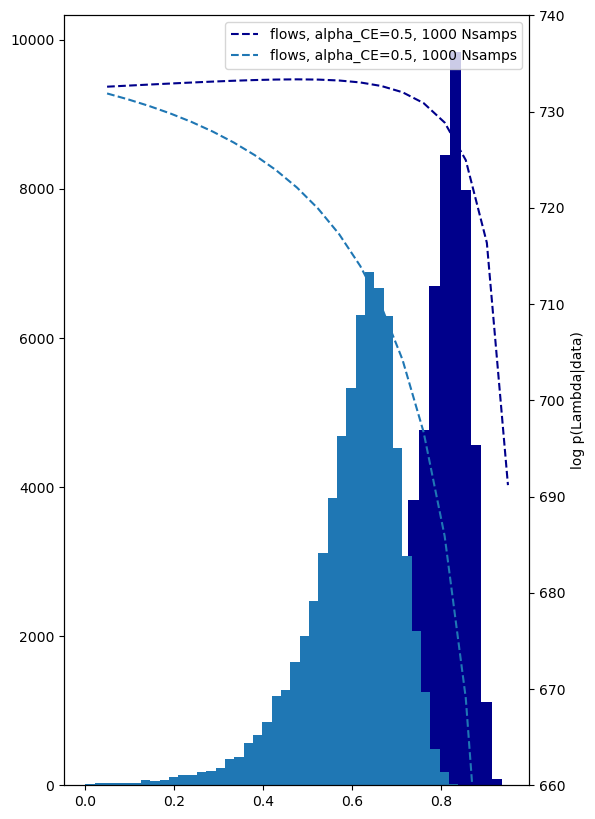

In [8]:
filename = '../rns/Flows_100724_simeventsdiscrete/output_seed12.hdf5'
result_file = h5py.File(filename, 'r')
samples_allchains = np.hstack([result_file['model_selection']['samples']['block1_values'], result_file['model_selection']['samples']['block0_values']])
hyper_idx =1
Nhyper=2
colors = ['darkblue', 'tab:blue']
plt.rcParams["figure.figsize"] = (6,10)

for midx in [1,2]:
    smdl_locs = np.argwhere(samples_allchains[:,hyper_idx]==midx).flatten()
    plt.hist(samples_allchains[smdl_locs, 2], color=colors[midx-1], bins=40)

p_betaCE_flow_alpha05_1000samps = np.load('flow_logprob_varyingbetaCE_1000Nsamp_alphaCE05.npy')
p_betaCE_flow_1000samps = np.load('flow_logprob_varyingbetaCE_1000Nsamp_alphaCE10.npy')

ax2 = plt.twinx()
ax2.set_ylim(660,740)
ax2.plot(np.linspace(0.05,0.95,20),p_betaCE_flow_alpha05_1000samps,color='darkblue', ls='dashed', label='flows, alpha_CE=0.5, 1000 Nsamps')
ax2.plot(np.linspace(0.05,0.95,20),p_betaCE_flow_1000samps,color='tab:blue', ls='dashed', label='flows, alpha_CE=0.5, 1000 Nsamps')

plt.ylabel('log p(Lambda|data)')
plt.xlabel('beta_CE')
plt.legend()

In [28]:
#varying beta_CE with flow models
no_points = 10

p_betaCE_flow=np.zeros(no_points)
alpha_flow=np.zeros(no_points)
chi_b_id = 2
alpha_id = 0


for i, beta_CE in enumerate(np.linspace(0.05,0.95,no_points)):
    sampler_hyperposts = [chi_b_id, alpha_id, beta_CE,(1-beta_CE)/5,(1-beta_CE)/5,(1-beta_CE)/5]
    betas = np.concatenate((sampler_hyperposts[2:], [1-np.sum(sampler_hyperposts[2:])]))

    alpha_flow[i]=0.
    for cidx, channel in enumerate(channels):
        beta = betas[cidx]
        if channel == 'CE':
            alpha_flow[i] += beta * flow[channel].alpha[tuple([chi_b_id, alpha_id])]
        else:
            alpha_flow[i] += beta * flow[channel].alpha[(chi_b_id)]

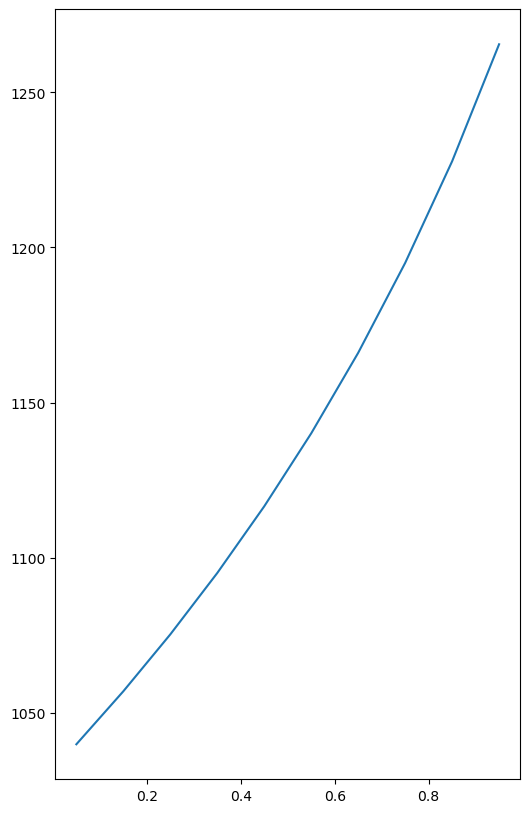

In [30]:

plt.plot(np.linspace(0.05,0.95,no_points),-np.log(alpha_flow)*obsdata.shape[0])